In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from palettable.cartocolors.sequential import PurpOr_6
from palettable.cartocolors.qualitative import Vivid_10
from palettable.cartocolors.qualitative import Vivid_8
from palettable.cartocolors.qualitative import Vivid_6

from ideotype.data_process import (read_data, 
                                   agg_sims, 
                                   parse_mature,
                                   fetch_sim_values,
                                   fetch_emps,
                                   process_clusters)
from ideotype.analysis import (rank_top_phenos, 
                               identify_top_phenos,
                               identify_improved_phenos, 
                               identify_rankchanged_phenos,
                               phenostage_climate,
                               run_pca)
from ideotype.figures import plot_sims_raw, plot_sims_phenostage
from ideotype.init_params import params_sample
from ideotype.utils import read_sim, fold
from ideotype.figures import (plot_params_heatmap,
                              plot_pca_strategies,
                              plot_strategies)

In [3]:
# fetch top phenos
phenos_topall = rank_top_phenos('present',20,1,1)
phenos_top20 = phenos_topall[:20]

# identify improved & declined phenos
n_pheno = 20
w_yield = 1
w_disp = 1
future_run = 'f2100'
rank_limit = 5

phenos_improved, phenos_declined, pup_rc, pdown_rc = identify_rankchanged_phenos(
    n_pheno, w_yield, w_disp, future_run, rank_limit)

print(phenos_improved)
print(phenos_declined)

[21, 25, 73, 18, 30, 89, 12, 79, 16, 7, 81, 5, 88, 54, 52, 9, 35]
[44, 58, 57, 59, 84, 85, 50, 48, 24, 62, 66]


In [4]:
# fetch emps
df_emps, df_emps_std = fetch_emps('present')
df_emps_sub = df_emps[df_emps.cvar.isin(phenos_topall)][['cvar', 'pheno_days', 'jday', 'LA']]
#df_emps_sub = df_emps[df_emps.cvar.isin(phenos_topall)][['cvar', 'pheno_days', 'jday', 'LA', 'An']]
#df_emps_sub = df_emps[df_emps.cvar.isin(phenos_topall)][['cvar', 'pheno_days', 'jday', 'An', 'gs', 'LA']]
#df_emps_sub = df_emps[df_emps.cvar.isin(phenos_topall)][['cvar', 'pheno_days', 'jday', 'LA', 'An', 'water_deficit_mean']]

# standardize df_emps
df_emps_sub_std = StandardScaler().fit_transform(df_emps_sub.iloc[:,1:])

# k-means cluster top-performing phenotypes
n_clusters = 8
kmeans_mod = KMeans(n_clusters=n_clusters)
kmeans_mod.fit(df_emps_sub_std)
y_kmeans = kmeans_mod.predict(df_emps_sub_std)
df_emps_sub['group'] = y_kmeans

# save cluster output
#df_emps_sub.to_csv('/home/disk/eos8/ach315/ideotype/ideotype/data/strategies_cluster/phenos_strategies_cluster.csv', index=False

# run pca
pca, df_pca = run_pca(df_emps_sub.iloc[:,1:-1], 3)

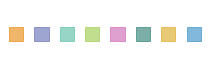

In [5]:
# color palette
fig = plt.figure(figsize=(3.5,1))
ax = fig.add_subplot(1,1,1)

cs_vivid8 = Vivid_8.mpl_colors
ax.scatter([1,2,3,4,5,6,7,8], [1,1,1,1,1,1,1,1],
            c=cs_vivid8, marker='s', s=200, alpha=0.6)

ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

In [ ]:
# visualization
#plot_pca_strategies(df_clusters, n_clusters, df_pca, pca, phenos_topall, cs)
#plot_pca_strategies(df_clusters, n_clusters, df_pca, pca, phenos_top20, cs)
#plot_pca_strategies(df_clusters, n_clusters, df_pca, pca, phenos_improved, cs)
#plot_pca_strategies(df_clusters, n_clusters, df_pca, pca, phenos_declined, cs)

#target = 'top20'
#target_threshold = 0.6
#emps = ['jday', 'pheno_days', 'LA']
#emps_text = ['grain-fill start', 'grain-fill duration', 'leaf area']

#targeted_groups, pheno_groups = process_clusters(
#    df_clusters, n_clusters, phenos_top20, phenos_improved, phenos_declined,
#    target, target_threshold)
#print(targeted_groups)
#print(pheno_groups)
#plot_strategies(emps, emps_text, targeted_groups, df_clusters, df_emps_std, cs)

### Pre-clustered results

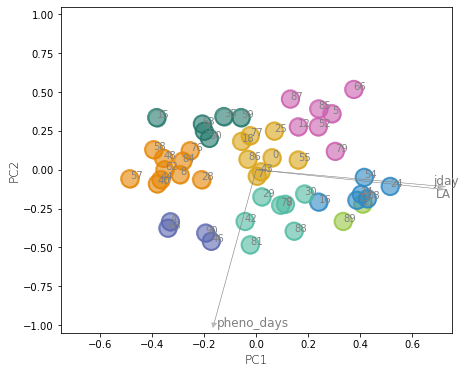

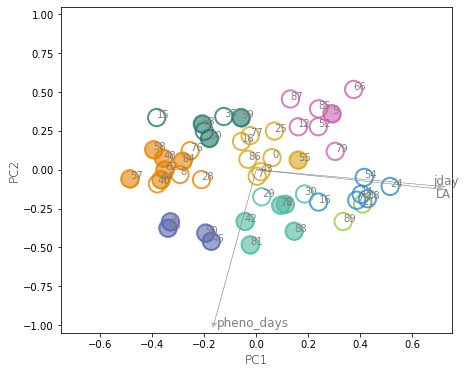

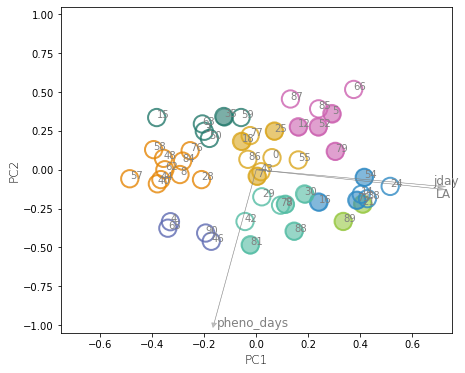

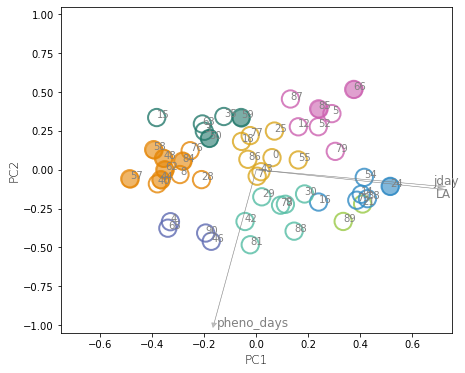

In [6]:
# read in clustered data
df_clusters = pd.read_csv('/home/disk/eos8/ach315/ideotype/ideotype/data/strategies_cluster/'
                          'phenos_strategies_phenomorph_cluster_8.csv')

# manually assign strategies colors
cs_vivid8 = Vivid_8.mpl_colors
cs = [np.nan]*n_clusters
cs[int(df_clusters.query('cvar==58').group)] = cs_vivid8[0]
cs[int(df_clusters.query('cvar==4').group)] = cs_vivid8[1]
cs[int(df_clusters.query('cvar==88').group)] = cs_vivid8[2]
cs[int(df_clusters.query('cvar==89').group)] = cs_vivid8[3]
cs[int(df_clusters.query('cvar==5').group)] = cs_vivid8[4]
cs[int(df_clusters.query('cvar==15').group)] = cs_vivid8[5]
cs[int(df_clusters.query('cvar==55').group)] = cs_vivid8[6]
cs[int(df_clusters.query('cvar==24').group)] = cs_vivid8[7]

# set up color palette
cs_vivid8 = Vivid_8.mpl_colors

# visualization
plot_pca_strategies(df_clusters, n_clusters, df_pca, pca, phenos_topall, cs)
plot_pca_strategies(df_clusters, n_clusters, df_pca, pca, phenos_top20, cs)
plot_pca_strategies(df_clusters, n_clusters, df_pca, pca, phenos_improved, cs)
plot_pca_strategies(df_clusters, n_clusters, df_pca, pca, phenos_declined, cs)

[1, 4, 6]
[[8, 28, 40, 44, 48, 57, 58, 62, 76, 84], [4, 46, 65, 90], [9, 29, 30, 42, 78, 81, 88]]


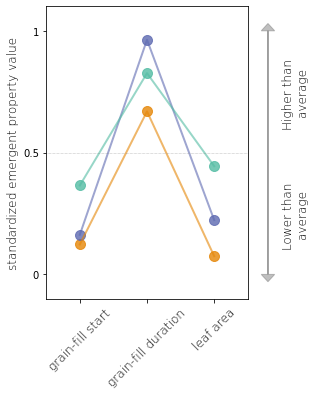

In [7]:
target = 'top20'
target_threshold = 0.6
emps = ['jday', 'pheno_days', 'LA']
emps_text = ['grain-fill start', 'grain-fill duration', 'leaf area']

targeted_groups, pheno_groups = process_clusters(
    df_clusters, n_clusters, phenos_top20, phenos_improved, phenos_declined,
    target, target_threshold)
print(targeted_groups)
print(pheno_groups)
plot_strategies(emps, emps_text, targeted_groups, df_clusters, df_emps_std, cs)
#                save=True, save_text='top20')

[0, 3, 5, 6]
[[21, 89], [5, 12, 52, 66, 79, 85, 87], [14, 16, 24, 38, 54, 73], [9, 29, 30, 42, 78, 81, 88]]


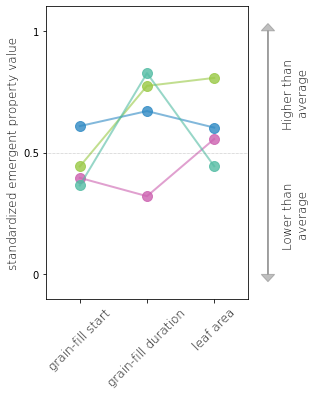

In [8]:
target = 'improved'
target_threshold = 0.5
emps = ['jday', 'pheno_days', 'LA']
emps_text = ['grain-fill start', 'grain-fill duration', 'leaf area']

targeted_groups, pheno_groups = process_clusters(
    df_clusters, n_clusters, phenos_top20, phenos_improved, phenos_declined,
    target, target_threshold)
print(targeted_groups)
print(pheno_groups)
plot_strategies(emps, emps_text, targeted_groups, df_clusters, df_emps_std, cs)
#                save=True, save_text='improved')

[1]
[[8, 28, 40, 44, 48, 57, 58, 62, 76, 84]]


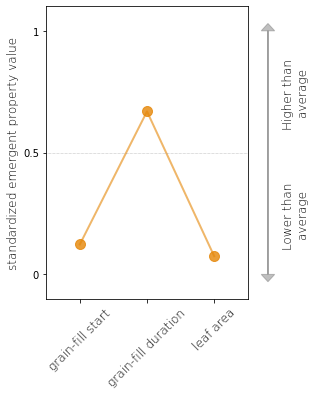

In [9]:
target = 'declined'
target_threshold = 0.6

emps = ['jday', 'pheno_days', 'LA']
emps_text = ['grain-fill start', 'grain-fill duration', 'leaf area']

targeted_groups, pheno_groups = process_clusters(
    df_clusters, n_clusters, phenos_top20, phenos_improved, phenos_declined,
    target, target_threshold)
print(targeted_groups)
print(pheno_groups)
plot_strategies(emps, emps_text, targeted_groups, df_clusters, df_emps_std, cs)
#                save=True, save_text='declined')

#### V update this code to plot current strategy groups

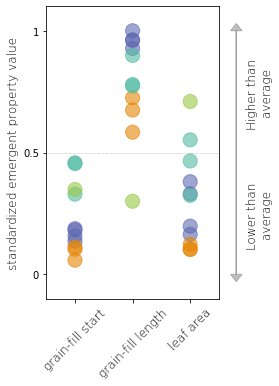

In [118]:
# phenos of interest
phenos = [4,65,46,90,  # slow aging
          8, 28, 40, 44, 48, 57, 58, 62, 76, 84,  # stress averters
          9, 29, 30, 42, 78, 81, 88]  # high yielders

# fig parameters
c1 = Vivid_4.mpl_colors[1]
c2 = Vivid_4.mpl_colors[0]
c3 = Vivid_4.mpl_colors[2]
c4 = Vivid_4.mpl_colors[3]
#c5 = 'mediumvioletred'

colors = [c1, c1, c1, c1,
          c2, c2, c2,
          c3, c3, c3, c4]

alphas=[0.6]*len(phenos)

# fetch emergent properties & standardize
gf_startdates = df_phenology[df_phenology.pheno=='"grainFill"'].groupby(['cvar']).mean()['jday']
gf_lengths = df_phenology[df_phenology.pheno=='"grainFill"'].groupby(['cvar']).mean()['pheno_days']
LAs = []
for pheno in np.arange(100):
    LA = df_leaves.query(f'cvar=={pheno}').groupby('site').max()['LA'].mean()
    LAs.append(LA)

gf_start_std = [(gf_startdates[pheno]-min(gf_startdates))/(max(gf_startdates)-min(gf_startdates)) for pheno in phenos]
gf_len_std = [(gf_lengths[pheno]-min(gf_lengths))/(max(gf_lengths)-min(gf_lengths)) for pheno in phenos]
la_std = [(LAs[pheno]-min(LAs))/(max(LAs)-min(LAs)) for pheno in phenos]

    
# visualization
fig = plt.figure(figsize=(6,7))
ax = fig.add_subplot(1,1,1)

ax.scatter([1]*len(phenos), gf_start_std, c=colors, s=200, alpha=alphas)
ax.scatter([2]*len(phenos), gf_len_std, c=colors, s=200, alpha=alphas)
ax.scatter([3]*len(phenos), la_std, c=colors, s=200, alpha=alphas)

#for item, pheno in enumerate(phenos):
#    ax.annotate(pheno, (1.15, gf_start_std[item]), color='grey')
#for item, pheno in enumerate(phenos):
#    ax.annotate(pheno, (2.15, gf_len_std[item]), color='grey')
#for item, pheno in enumerate(phenos):
#    ax.annotate(pheno, (3.15, la_std[item]), color='grey')

ax.set_xlim(0.5, 3.5)
ax.set_ylim(-0.1, 1.1)
ax.set_xticks([1,2,3])
ax.set_xticklabels(['grain-fill start', 'grain-fill length', 'leaf area'], 
                   rotation=45, fontweight='light', fontsize=12)
ax.set_yticks([0,0.5,1])
ax.set_yticklabels([0,0.5,1])
ax.set_ylabel('standardized emergent property value', fontweight='light', fontsize=12)
ax.axhline(y=0.5, color='grey', linewidth=0.5, linestyle=':')


ax.arrow(3.8, 0, 0, 1, color='grey', alpha=0.5,
         head_length=0.03, head_width=0.2, clip_on=False)
ax.arrow(3.8, 1, 0, -1, color='grey', alpha=0.5,
         head_length=0.03, head_width=0.2, clip_on=False)

ax.annotate('Lower than \naverage', (4.2, 0.25), 
            ha='center', va='center', fontweight='light', 
            fontsize=12, rotation=90,
            annotation_clip=False)
ax.annotate('Higher than \naverage', (4.2, 0.75), 
            ha='center', va='center', fontweight='light', 
            fontsize=12, rotation=90,
            annotation_clip=False)

fig.subplots_adjust(left=0.3, right=0.7, bottom=0.3)

#plt.savefig('/home/disk/eos8/ach315/upscale/figs/scatter_strategies.png', format='png', dpi=800)

## Strategies

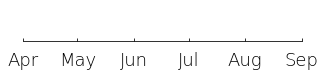

In [601]:
fig = plt.figure(figsize=(5,1))
ax = fig.add_subplot(1,1,1)
ax.set_xlim(91,244)
ax.set_xticks([91, 121, 152, 182, 213, 244])
ax.set_xticklabels(['Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep'], 
                   fontweight='light', fontsize=18)
ax.tick_params(axis='x', direction='in', pad=10)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_visible(False)

fig.subplots_adjust(bottom=0.4)

#plt.savefig('/home/disk/eos8/ach315/upscale/figs/phenostage_timeline.png', format='png', dpi=800)

## Mechanisms

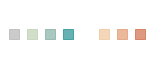

In [800]:
fig = plt.figure(figsize=(2.5,1))
ax = fig.add_subplot(1,1,1)

colors = ['darkgrey', 
          Geyser_7.mpl_colors[2],
          Geyser_7.mpl_colors[1],
          Geyser_7.mpl_colors[0],          
          Geyser_7.mpl_colors[-3],
          Geyser_7.mpl_colors[-2],
          Geyser_7.mpl_colors[-1]]

ax.scatter([1,2,3,4,6,7,8], [1,1,1,1,1,1,1],
            c=colors, marker='s', s=100, alpha=0.6)

ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

#plt.savefig('/home/disk/eos8/ach315/upscale/figs/cpalette_phenostages.png', format='png', dpi=800)

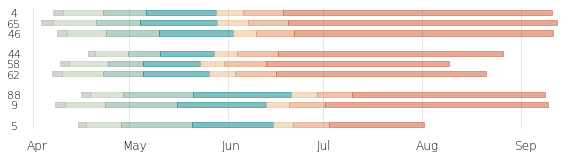

In [806]:
# identify targeted phenos
phenos = [4,65,46,44,58,62,88,9,5]
df_phenology_grouped = df_phenology.groupby(['cvar', 'pheno']).mean()
df_phenos = df_phenology_grouped.query(f'cvar in {phenos}')  

# set up phenostages
phenostages = [['"none"', '"Germinated"'],
               ['"Germinated"', '"Emerged"'],
               ['"Emerged"', '"Tasselinit"'],
               ['"Tasselinit"', '"Tasseled"'],
               ['"Tasseled"', '"Silked"'],
               ['"Silked"', '"grainFill"'],
               ['"grainFill"', '"Matured"']]
        
colors = ['darkgrey', 
          Geyser_7.mpl_colors[2],
          Geyser_7.mpl_colors[1],
          Geyser_7.mpl_colors[0],          
          Geyser_7.mpl_colors[-3],
          Geyser_7.mpl_colors[-2],
          Geyser_7.mpl_colors[-1]]

# visualization
fig = plt.figure(figsize=(10,2.5))

ax = fig.add_subplot(1,1,1)
ax.plot([85,270],[0,10], alpha=0)
ax.set_xlim(85,260)
ax.set_ylim(0.8,12.8)

jday_months = [91, 121, 152, 182, 213, 244, 274, 305, 335, 350]
for jday_month in jday_months:
    ax.axvline(x=jday_month, color='grey', linewidth=0.5, linestyle=':')

for phenostage, color in zip(phenostages, colors):
    df_phenostage1 = df_phenos[
        df_phenos.index.get_level_values('pheno') == f'{phenostage[0]}'].reset_index()
    df_phenostage1.index = df_phenostage1.cvar
    df_phenostage1 = df_phenostage1.reindex(phenos)

    df_phenostage2 = df_phenos[
        df_phenos.index.get_level_values('pheno') == f'{phenostage[1]}'].reset_index()
    df_phenostage2.index = df_phenostage2.cvar
    df_phenostage2 = df_phenostage2.reindex(phenos)

    cvars1 = np.arange(len(phenos))
    cvars2 = np.arange(len(phenos))

    jdays_start = np.empty(len(phenos))
    jdays_start[:] = np.nan
    jdays_start[cvars1] = list(df_phenostage1.jday.values)

    jdays_end = np.empty(len(phenos))
    jdays_end[:] = np.nan
    jdays_end[cvars2] = list(df_phenostage2.jday.values)

    jdays_len = [jend - jstart for jend, jstart in zip(jdays_end, jdays_start)]
    rankings = list(np.arange(len(phenos)))
    rankings.reverse()
    
    poss = [12,11,10,8,7,6,4,3,1]
    for item in np.arange(len(phenos)):
        rect = patches.Rectangle((jdays_start[item], poss[item]), 
                                 jdays_len[item], 0.5,
                                 color=color, alpha=0.5, clip_on=False)
        ax.add_patch(rect)

# invisible spines & axes
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.tick_params(axis='y', direction='in', pad=10)

# annotate x & y axis info
xs = [91, 121, 152, 182, 213, 244]
months = ['Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep']
for item in np.arange(len(months)):
    ax.text(xs[item]-2, -1.2, months[item], 
            fontweight='light', fontsize=12, clip_on=False)

for pos, pheno in zip(poss, phenos):
    ax.text(85, pos-0.2, pheno, 
            fontweight='light', fontsize=11, clip_on=False, ha='center')

fig.subplots_adjust(bottom=0.2)

#plt.savefig('/home/disk/eos8/ach315/upscale/figs/bars_phenostage_strategies.png', format='png', dpi=800)

### *** Try remaking these plots to show standardized values compared to all phenotypes and simplify y axis vvv

In [ ]:
df = df_phys
phenostage = '"Emerged"'
mechanism = 'An'
phenos_all = np.arange(100)
phenos = [4,65,46,44,58,62,88,9,5]
sims_all = fetch_sim_values(df, phenostage, mechanism, phenos_all)
sims = fetch_sim_values(df, phenostage, mechanism, phenos)
[(sim - min(sims_all))/max(sims_all) for sim in sims]

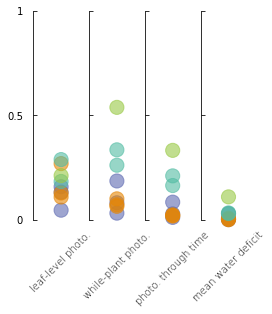

In [296]:
# identify phenos
phenos_all = np.arange(100)
phenos = [4,65,46,44,58,62,88,9,5]

# set up fig parameters
c1 = Vivid_4.mpl_colors[1]
c2 = Vivid_4.mpl_colors[0]
c3 = Vivid_4.mpl_colors[2]
c4 = Vivid_4.mpl_colors[3]
colors = [c1, c1, c1, c2, c2, c2, c3, c3, c4]
alphas=[0.6]*9

phenostage = '"Emerged"'
dfs = [df_phys, df_phys, df_carbon, df_waterdeficit]
mechanisms = ['An', 'pn', 'pn_sum', 'water_deficit_mean']
xlabels = ['leaf-level photo.', 'while-plant photo.', 'photo. through time', 'mean water deficit']

# visualization
fig = plt.figure(figsize=(4,5))

for count, (df, mechanism) in enumerate(zip(dfs, mechanisms)):
    ax = fig.add_subplot(1,4,count+1)
    sims_all = fetch_sim_values(df, phenostage, mechanism, phenos_all)
    sims = fetch_sim_values(df, phenostage, mechanism, phenos)
    sims_std = [(sim - min(sims_all))/max(sims_all) for sim in sims]

    if count == 3:
        sims_all = [sim*-1 for sim in sims_all]
        sims = [sim*-1 for sim in sims]
        sims_std = [(sim - min(sims_all))/max(sims_all) for sim in sims]

    ax.scatter([1]*len(phenos), sims_std,
               s=200, c=colors, alpha=alphas, clip_on=False)

    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    ax.set_xticks([0])
    ax.set_xticklabels([0])
    ax.set_xlabel(xlabels[count], rotation=45, labelpad=10,
                  fontsize=10, fontweight='light')
    ax.set_ylim(0,1)
    ax.set_yticks([0,0.5,1])
    
    if count == 0:
        ax.set_yticklabels([0,0.5,1])
    else:
        ax.set_yticklabels(['','',''])
    ax.tick_params(axis='y', direction='in', pad=10)

fig.subplots_adjust(wspace=0, bottom=0.3)

#plt.savefig('/home/disk/eos8/ach315/upscale/figs/scatter_mechanisms_veg.png', format='png', dpi=800)

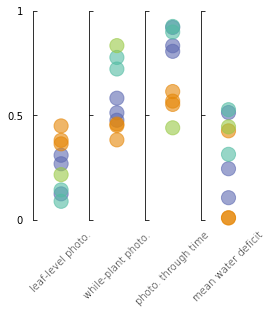

In [297]:
# identify phenos
phenos_all = np.arange(100)
phenos = [4,65,46,44,58,62,88,9,5]

# set up fig parameters
c1 = Vivid_4.mpl_colors[1]
c2 = Vivid_4.mpl_colors[0]
c3 = Vivid_4.mpl_colors[2]
c4 = Vivid_4.mpl_colors[3]
colors = [c1, c1, c1, c2, c2, c2, c3, c3, c4]
alphas=[0.6]*9

phenostage = '"grainFill"'
dfs = [df_phys, df_phys, df_carbon, df_waterdeficit]
mechanisms = ['An', 'pn', 'pn_sum', 'water_deficit_mean']
xlabels = ['leaf-level photo.', 'while-plant photo.', 'photo. through time', 'mean water deficit']

# visualization
fig = plt.figure(figsize=(4,5))

for count, (df, mechanism) in enumerate(zip(dfs, mechanisms)):
    ax = fig.add_subplot(1,4,count+1)
    sims_all = fetch_sim_values(df, phenostage, mechanism, phenos_all)
    sims = fetch_sim_values(df, phenostage, mechanism, phenos)
    sims_std = [(sim - min(sims_all))/max(sims_all) for sim in sims]

    if count == 3:
        sims_all = [sim*-1 for sim in sims_all]
        sims = [sim*-1 for sim in sims]
        sims_std = [(sim - min(sims_all))/max(sims_all) for sim in sims]

    ax.scatter([1]*len(phenos), sims_std,
               s=200, c=colors, alpha=alphas, clip_on=False)

    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    ax.set_xticks([0])
    ax.set_xticklabels([0])
    ax.set_xlabel(xlabels[count], rotation=45, labelpad=10,
                  fontsize=10, fontweight='light')
    ax.set_ylim(0,1)
    ax.set_yticks([0,0.5,1])
    if count == 0:
        ax.set_yticklabels([0,0.5,1])
    else:
        ax.set_yticklabels(['','',''])
    ax.tick_params(axis='y', direction='in', pad=10)

fig.subplots_adjust(wspace=0, bottom=0.3)

#plt.savefig('/home/disk/eos8/ach315/upscale/figs/scatter_mechanisms_rep.png', format='png', dpi=800)